In [1]:
import json
import bz2
import regex
import re
from tqdm import tqdm
from scipy import sparse
from string import punctuation
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    counter = 0
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
        if len(responses) > 100000: # to reduce testing
            break


134220it [02:28, 906.42it/s] 



Посмотрим на пример отзыва:

In [4]:
responses[:1]

[{'city': 'г. Москва',
  'rating_not_checked': False,
  'title': 'Жалоба',
  'num_comments': 0,
  'bank_license': 'лицензия № 2562',
  'author': 'uhnov1',
  'bank_name': 'Бинбанк',
  'datetime': '2015-06-08 12:50:54',
  'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом 

In [5]:
df = pd.DataFrame(responses)
responses = None
# df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


## Часть 1. Анализ текстов


### 1.1. Количество отзывов в разных городах и на разные банки

In [6]:
# Количество отзывов в разных городах
df.city.value_counts()

г. Москва                           39216
г. Санкт-Петербург                  10501
г. Новосибирск                       1714
г. Екатеринбург                      1710
г. Нижний Новгород                   1503
                                    ...  
г. Посьет (Приморский край)             1
г. Приобье                              1
г. омск (Санкт-Петербург)               1
г. Улан-Удэ (Республика Бурятия)        1
г. Курск-Орел                           1
Name: city, Length: 4161, dtype: int64

In [7]:
# Количество отзывов на разные банки
df.bank_name.value_counts()


Сбербанк России                 18627
Альфа-Банк                       6335
Хоум Кредит Банк                 5927
Русский Стандарт                 5170
ВТБ 24                           4923
                                ...  
Вологжанин                          1
Развитие                            1
Кубаньторгбанк                      1
Дойче Банк                          1
Хакасский Муниципальный Банк        1
Name: bank_name, Length: 506, dtype: int64

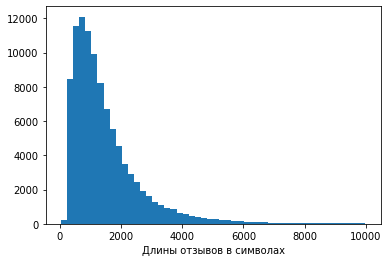

In [8]:
### 1.2. Гистограмы длин отзывов в символах и в словах

len_c = df.text.apply(len)
len_c[len_c<10000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

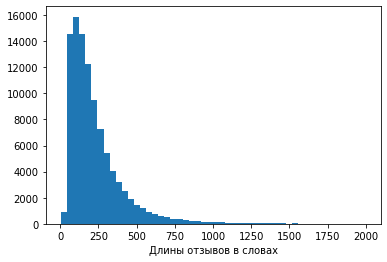

In [9]:
len_t = df.text.str.split().apply(len)
len_t[len_t<2000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в словах')
plt.ylabel('')
plt.show()

### 1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных

In [11]:
# 10 самых частых слов
nltk.download('punkt')
tokens_without_punctuation = [token for comment in df.text for token in word_tokenize(
    comment) if token not in punctuation]
    
freq_dict = Counter(tokens_without_punctuation)
freq_dict.most_common(10)


[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('в', 736804),
 ('и', 616852),
 ('не', 520844),
 ('на', 404115),
 ('что', 381879),
 ('я', 282980),
 ('с', 273420),
 ('по', 220099),
 ('мне', 190471),
 ('банка', 154894)]

In [12]:
# 10 самых частых слов без стоп-слов
nltk.download('stopwords')
noise = stopwords.words('russian') + ["``", "''", "...", "."]
tokens_without_stopwords = [token for comment in tokens_without_punctuation for token in word_tokenize(
    comment) if token not in noise]
Counter(tokens_without_stopwords).most_common(10)


[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('банка', 154900),
 ('банк', 103800),
 ('это', 97252),
 ('В', 95110),
 ('Я', 83755),
 ('деньги', 76684),
 ('карты', 64254),
 ('карту', 64175),
 ('день', 49335),
 ('кредит', 46516)]

In [13]:
# 10 самых частых лемм
m = Mystem()


def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()
    except:
        return " "


Installing mystem to /home/alex/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [14]:
mystoplemmas = stopwords.words(
    'russian') + ['который', 'прошлый', 'сей', 'свой', 'наш', 'мочь', 'г']


def remove_stoplemmas(text, mystoplemmas=mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""


In [15]:
df['lemma'] = df['text'].apply(lemmatize)


In [16]:
# 10 самых частых лемм (оч долго работает)
# mystem_analyzer = Mystem()

# lemmatized_tokens = [token for comment in tokens_without_stopwords for token in mystem_analyzer.lemmatize(
#     comment) if token not in noise]
# lemmatized_tokens[:5]


In [17]:
# 10 самых частых существительных
# morph_analyzer = MorphAnalyzer()

# nouns = [noun for noun in lemmatized_tokens if morph_analyzer.parse(noun)[
#     0].tag.POS == 'NOUN']

# Counter(nouns).most_common(10)


## 1.4. Постройте кривые Ципфа и Хипса

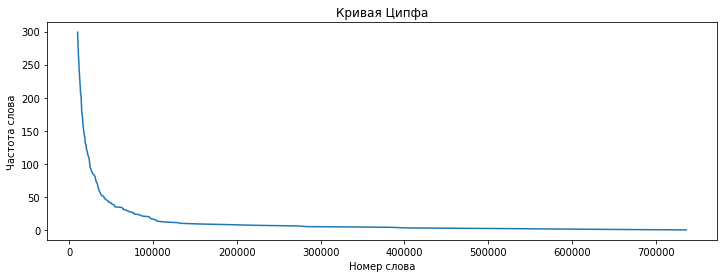

In [18]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse=True)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.show()


In [19]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    tokens = word_tokenize(row.text)
    n_words.append(len(cnt))
    n_tokens.append(sum(len(cnt.values())))




100%|██████████| 100001/100001 [04:00<00:00, 415.96it/s]


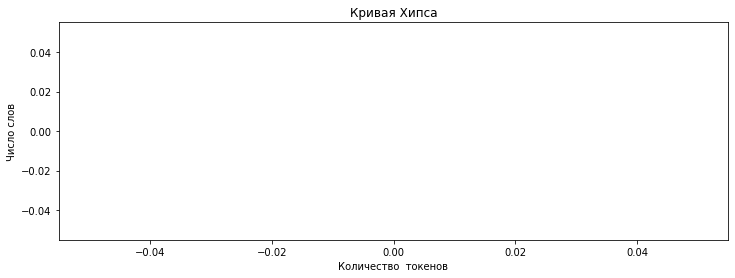

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(n_tokens, n_words)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.show()


## 1.5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [21]:
Freq_Dist = FreqDist(tokens_without_stopwords)


In [22]:
print('Слово "сотрудник" встречается -"', Freq_Dist['сотрудник'], 'раз')
print('Слово "клиент" встречается -"', Freq_Dist['клиент'], 'раз')

Слово "сотрудник" встречается -" 17416 раз
Слово "клиент" встречается -" 9710 раз


In [23]:
print('Слово "мошенничество" встречается -"', Freq_Dist['мошенничество'], 'раз')
print('Слово "доверие" встречается -"', Freq_Dist['доверие'], 'раз')

Слово "мошенничество" встречается -" 691 раз
Слово "доверие" встречается -" 657 раз


## 1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)


In [24]:
df['rating_grade'].value_counts()


1.0    28229
2.0     8581
5.0     5874
3.0     4726
4.0     1758
Name: rating_grade, dtype: int64

In [25]:
# Сбалансируем выборки
num = 5000

df_sample = df[(df.rating_grade == 1)].sample(n=num).copy()
df_sample = df_sample.append(df[(df.rating_grade == 5)].sample(n=num))

df_sample.rating_grade.value_counts()


/tmp/ipykernel_8357/1109473200.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sample = df_sample.append(df[(df.rating_grade == 5)].sample(n=num))


1.0    5000
5.0    5000
Name: rating_grade, dtype: int64

In [26]:
tokens_by_topic = []

for rating in df_sample.rating_grade.unique():
    tokens = []
    sample = df_sample[df_sample['rating_grade'] == rating]

    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()

    tokens_by_topic.append(tokens)


In [27]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=0)
tfidf_matrix = tfidf.fit_transform(
    [' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names()
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(
    range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)

text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(
    range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase)
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,
                        'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)


/home/alex/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,то что,сказать что
1,не быть,то что
2,другой банк,не мочь
3,интернет банк,не быть
4,сказать что,сотрудник банк
5,этот банк,на мой
6,сотрудник банк,денежный средство
7,так как,на счет
8,кредитный карта,сообщать что
9,банк не,банк не


## Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

In [29]:
import gensim.corpora as corpora
from gensim.models import ldamodel


In [30]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


In [31]:
random.seed(11)


In [32]:
lda = ldamodel.LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=20,
                        alpha='auto',
                        eta='auto',
                        iterations=20,
                        passes=5)


In [33]:
# 20 тем, рандомная выборка 5
lda.show_topics(5)


[(10,
  '0.000*"руб.*"" + 0.000*"88001001144"" + 0.000*"drbanki:" + 0.000*"кузьминки)." + 0.000*"графа:" + 0.000*"отличаться"" + 0.000*""и.о." + 0.000*""мико-пенсионный"" + 0.000*"послестория:" + 0.000*"напечатать»…"'),
 (9,
  '0.009*"неудобно." + 0.004*"EUR" + 0.002*""внутренний" + 0.002*"bank" + 0.002*"is" + 0.002*"обман?" + 0.001*"Limit" + 0.001*"вернуть"." + 0.000*"your" + 0.000*"you"'),
 (7,
  '0.130*"я" + 0.056*"что" + 0.042*"в" + 0.035*"и" + 0.026*"она" + 0.025*"на" + 0.021*"не" + 0.019*"сказать," + 0.018*"отделение" + 0.016*"позвонить"'),
 (13,
  '0.055*"в" + 0.033*"банк" + 0.031*"не" + 0.030*"на" + 0.024*"и" + 0.023*"что" + 0.021*"по" + 0.017*"о" + 0.017*"сотрудник" + 0.016*"банк,"'),
 (16,
  '0.047*"не" + 0.039*"и" + 0.036*"в" + 0.023*"что" + 0.023*"-" + 0.021*"на" + 0.018*"а" + 0.014*"это" + 0.013*"но" + 0.011*"быть"')]

In [34]:
lda15 = ldamodel.LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=15,
                          alpha='auto',
                          eta='auto',
                          iterations=20,
                          passes=5)


In [35]:
# 25 тем, рандомная выборка 5
lda15.show_topics(5)


[(6,
  '0.089*"вклад" + 0.036*"открывать" + 0.023*"вклад," + 0.019*"на" + 0.018*"вклад." + 0.018*"процент" + 0.016*"банк" + 0.014*"сумма" + 0.014*"в" + 0.014*"по"'),
 (4,
  '0.036*"в" + 0.022*"договор" + 0.020*"и" + 0.017*"банк" + 0.016*"на" + 0.013*"с" + 0.011*"о" + 0.010*"по" + 0.009*"право" + 0.009*"от"'),
 (3,
  '0.039*"и" + 0.028*"вы" + 0.027*"не" + 0.024*"а" + 0.020*"все" + 0.013*"но" + 0.013*"что" + 0.013*"мы" + 0.013*"вот" + 0.013*"как"'),
 (12,
  '0.061*"в" + 0.034*"-" + 0.034*"не" + 0.031*"и" + 0.026*"на" + 0.017*"с" + 0.013*"по" + 0.012*"быть" + 0.011*"банк" + 0.010*"это"'),
 (14,
  '0.097*"я" + 0.050*"что" + 0.048*"в" + 0.047*"и" + 0.040*"не" + 0.028*"на" + 0.018*"быть" + 0.015*"мой" + 0.011*"с" + 0.010*"банк"')]

In [36]:
lda10 = ldamodel.LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=10,
                          alpha='auto',
                          eta='auto',
                          iterations=20,
                          passes=5)


In [37]:
# 10 тем
lda10.show_topics(5)


[(4,
  '0.006*"персональный" + 0.004*"финанс" + 0.004*"энд" + 0.003*"обработка" + 0.002*"данные"." + 0.002*"«кб" + 0.002*"лариса" + 0.001*"г-вой" + 0.001*""национальный" + 0.001*"152-фз"'),
 (6,
  '0.066*"терминал" + 0.017*"кошелек" + 0.013*"терминал," + 0.011*"киви" + 0.011*"разблокировка" + 0.011*"•" + 0.009*"терминал." + 0.008*"служба" + 0.007*"поддержка" + 0.007*"QIWI"'),
 (5,
  '0.040*"я" + 0.039*"и" + 0.035*"не" + 0.026*"в" + 0.021*"с" + 0.017*"банк" + 0.016*"мой" + 0.016*"что" + 0.014*"на" + 0.014*"вы"'),
 (8,
  '0.056*"в" + 0.029*"я" + 0.027*"на" + 0.023*"по" + 0.020*"быть" + 0.020*"и" + 0.018*"банк" + 0.016*"с" + 0.015*"не" + 0.013*"что"'),
 (0,
  '0.055*"я" + 0.043*"в" + 0.037*"что" + 0.034*"не" + 0.032*"и" + 0.025*"на" + 0.010*"она" + 0.010*"быть" + 0.009*"отделение" + 0.009*"сказать,"')]

## Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

# На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



# clf = Pipeline([ 
#     ('vect', CountVectorizer()), 
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD()), 
#     ('clf', RandomForestClassifier())
# ])


In [44]:
X = df_sample['lemma'].values
y = df_sample.rating_grade.values
X.shape, y.shape


((10000,), (10000,))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [46]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']  
}

scores=['accuracy', 'f1']

In [48]:
grid_cntv = GridSearchCV(
    clf_countvectorized,
    param_grid=params_cntv,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)


In [49]:
grid_cntv.fit(X_train, y_train)


Fitting 3 folds for each of 252 candidates, totalling 756 fits


/home/alex/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alex/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'vect__analyzer': ['word', 'char'],
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__ngram_range': ((1, 1), (2, 2), (3, 3))},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [51]:
predictions = grid_cntv.best_estimator_.predict(X_test)

print("Best score: %0.3f" % grid_cntv.best_score_)
print("Precision: {0:6.2f}".format(
    precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(
    recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(
    f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))


Best score: 0.942
Precision:   0.94
Recall:      0.94
F1_score:    0.94
Accuracy:    0.94
